# Constructing K-correction files

This python notebook guides you to construct a file that contains the K-corrections for your transient.

For this notebook it is important to have the python package SNCosmo installed. 
Your transient model should also already be installed in the SNCosmo package. The name of this model has to be filled in under "Modelname".

The resulting datafile will contain a 2D grid  with the K-correction relative to the observer frame: as a function of time after outburst and as a function of redshift. It also contains the time dilation that is associated with a redshifted transient.

In [1]:
import sncosmo
import matplotlib.pyplot as plt
import numpy as np
import h5py
from IPython.display import HTML
from scipy.interpolate import interp1d
from matplotlib import animation
from astropy.cosmology import FlatLambdaCDM
#Hubble parameters from Planck 2015
H_0 = 67.3
Omega_M = 0.315

#Other constants:
h_planck = 6.626e-27	#erg s^-1
dist_cm = 3.08567758e19	#cm = 10 parsec	(We want absolute magnitudes)

One may want to define their own bandpasses. This is typically done for telescopes that don't use the standard filters. Please enter the file name (with one column wavelength in Angstrom, the second column transmission in decimals) into the "Bandpass_data" list. This file should be located in the Auxiliary/Bandpasses directory. Please enter the corresponding filter name you wish it to give in the "Bandpass_names" list. You can now use this name throughout this script. Please also rewrite parts of the script that contain 'bessellb' to incorporate your own bandpasses.

In [2]:
Bandpass_data = ['sK.dat', 'sH.dat', 'sJ.dat']
Bandpass_names = ['bessellk', 'bessellh', 'bessellj']

def Install_bandpass(Fname, Name):
    Data = np.genfromtxt('Bandpasses/' + Fname).T
    band = sncosmo.Bandpass(Data[0], Data[1], name=Name)
    sncosmo.register(band)
    
for i, fname in enumerate(Bandpass_data):
    Install_bandpass(fname, Bandpass_names[i])

Choose the model source and its peak-magnitude in the Bessel-R band. This is necessary because not every model has the same peak mag: some are in absolute and some in apparent magnitudes and some are completely different. Do not forget to normalize to the H_0 that is used to state the estimated peak-magnitude

In [3]:
Modelname = 'nugent-sn1a'#'snana-2006kv'
model = sncosmo.Model(source=Modelname)
model.cosmo = FlatLambdaCDM(H0=H_0, Om0=Omega_M)

peak_R = -18.67 + 5 * np.log10(H_0/73.)    ##Li2011 use H0=73
model.source.set_peakmag(peak_R,band = 'bessellr',magsys = 'vega')

#Sometimes the flux can temporarily drop to 30 mags or so. We want to prevent that. Therefore we set a faint limit for our transient
faint_lim = 10.

In [4]:
peak_R

-18.846538979482396

These models will be redshifted. We therefore want to know what the maximum redshift (in Angstrom) is up to which we can determine the K-corrections. This requires us knowing the minimum wavelength of the SN model. Up to what redshift can we shift that wavelength, such that it still falls into the U/u-band?

In [4]:
Lambda_emit = model.minwave()
#Lowest observable wavelength:
Lambda_obs = min(sncosmo.get_bandpass('bessellux').wave[0], sncosmo.get_bandpass('sdssu').wave[0])
Zmax = min((Lambda_obs - Lambda_emit) / Lambda_emit, 2)
redshifts = np.linspace(0,Zmax,100)

#We need to define the wavelength range over which to compute our models
#Maximum observable wavelength
Lambda_max = max(sncosmo.get_bandpass('bessellk').wave[-1], sncosmo.get_bandpass('sdssz').wave[-1])
spectrum = [x for x in model.source._wave if x >= Lambda_obs and x <= Lambda_max ]

We need to define the times at which we want to see the K-corrections. The sncosmo model has a maximum time where the light curve ends. However, the K-corrections also take time dilation into account, so the end time of the light curves get stretched. The time at redshift Zmax is the last time at which we want to evaluate the K corrections. In many SNCosmo models T=0 is defined at Bmax, while at others it denotes the start of the LC (i.e. at T=0 B!=Bmax)

In [5]:
LC_start = -20.0
Tmax = model.maxtime() * (1 + Zmax)
Tmin = model.mintime() * (1 + Zmax)
times = np.linspace(Tmin, Tmax, 150) 
print "In the transient entry in dataTransients.dat please enter the following number under the column 'bright time': ", Tmax + abs(Tmin)

In the transient entry in dataTransients.dat please enter the following number under the column 'bright time':  270.0


SNCosmo interpolates several observed spectra with polynomials. This means that at times the fluxes at certain wavelengths might drop below zero. We've got to prevent this. We need to define a function to obtain a broadband magnitude ourselves.

In [6]:

AB_to_Vega = {'bessellux':-0.79, 'bessellb':0.09, 'bessellv':-0.02, 'bessellr':-0.21, 'besselli':-0.45, 'bessellj': -0.91, 'bessellh': -1.39, 'bessellk': -1.85, 'sdssu': -0.91, 'sdssg': 0.08, 'sdssr':-0.16, 'sdssi': -0.37, 'sdssz': -0.54}
Bessell = ['bessellux', 'bessellb', 'bessellv', 'bessellr', 'besselli', 'bessellj']
def getbbAB( spec, bandpass, dist_cm ):
    filter = sncosmo.get_bandpass(bandpass)
    wl, tr = filter.wave, filter.trans
    filt = interp1d( wl, tr )
    area = 4.0*np.pi*dist_cm*dist_cm
    # gra the region of the spectrum that falls within the filter limits
    spec = spec[ (spec[:,0] >= wl[0]) & (spec[:,0] <= wl[-1]) ]
    lams_A, flx_A = spec[:,0], spec[:,1]/area
    # convert to flux/frequency in Janskys
    fv_Jansk= 3.34e4 * lams_A*lams_A * flx_A
    
    #If a flux is negative or zero, we need to convert it to a very small number (which is not zero)
    Neg_flux = fv_Jansk <= 0
    fv_Jansk[Neg_flux] = 1e-99
    nus = 3.0e18/lams_A
    dNu = (3.0e18/lams_A/lams_A) * (lams_A[1]-lams_A[0])
    tr_nu = filt(lams_A)
    numer = np.sum( fv_Jansk * (1.0/h_planck*nus) * tr_nu * dNu)
    denom = 3631.0 * np.sum( (1.0/h_planck*nus) * tr_nu * dNu)
    mag = -2.5*np.log10(numer/denom)


    if mag + AB_to_Vega[bandpass] < faint_lim:
        if bandpass in Bessell:
            return mag + AB_to_Vega[bandpass]
        else:
            return mag
    else:
        return faint_lim


Now we need four functions for the two different color systems and as a function of T and Z. The functions of Z merely serve as an illustration-function only used in the animation down below

In [7]:
def Bessell_T(times, Z):
    U = []
    B = []
    V = []
    R = []
    I = []
    days = []
    model.set(z=Z)
    Luminosity_old = model.flux( times[0], spectrum) * 4.0* np.pi * dist_cm * dist_cm
    for phase in times:
        Luminosity = model.flux( phase, spectrum) * 4.0* np.pi * dist_cm * dist_cm

        for i, flux in enumerate(Luminosity):
            if flux <=0:      #If the flux at one wavelength is zero, take the flux at the phase before.
                Luminosity[i] = Luminosity_old[i]
                #Luminosity[i] = 1.e-99      #Different possibility
        Spec = np.array([spectrum,Luminosity])
        U.append(getbbAB(Spec.T, 'bessellux', dist_cm))
        B.append(getbbAB(Spec.T, 'bessellb', dist_cm))
        V.append(getbbAB(Spec.T, 'bessellv', dist_cm))
        R.append(getbbAB(Spec.T, 'bessellr', dist_cm))
        I.append(getbbAB(Spec.T, 'besselli', dist_cm))
        days.append(phase)
        Luminosity_old = Luminosity
        #The model s11-2004hx has a strange defect where it quickly drops to very faint magnitudes just before the rise starts.
        if Modelname == 's11-2004hx':  
            if U[-1] > U[0]: U[-1] = U[0]
            if B[-1] > B[0]: B[-1] = B[0]
            if V[-1] > V[0]: V[-1] = V[0]
            if R[-1] > R[0]: R[-1] = R[0]
            if I[-1] > I[0]: I[-1] = I[0]
    return U,B,V,R,I,days

def Bessell_Z(times, redshifts, j):
    U = []
    B = []
    V = []
    R = []
    I = []
    days = []
    if j !=0:
        Luminosity_old = model.flux( times[j-1], spectrum) * 4.0* np.pi * dist_cm * dist_cm
    else:
        Luminosity_old = model.flux( times[j], spectrum) * 4.0* np.pi * dist_cm * dist_cm     
    for Z in redshifts:
        model.set(z=Z)
        Luminosity = model.flux( times[j], spectrum) * 4.0* np.pi * dist_cm * dist_cm
        
        for i, flux in enumerate(Luminosity):
            if flux <=0:      #If the flux at one wavelength is zero, take the flux at the phase before.
                Luminosity[i] = Luminosity_old[i]
                #Luminosity[i] = 1.e-99      #Different possibility
        Spec = np.array([spectrum,Luminosity])
        U.append(getbbAB(Spec.T, 'bessellux', dist_cm))
        B.append(getbbAB(Spec.T, 'bessellb', dist_cm))
        V.append(getbbAB(Spec.T, 'bessellv', dist_cm))
        R.append(getbbAB(Spec.T, 'bessellr', dist_cm))
        I.append(getbbAB(Spec.T, 'besselli', dist_cm))
    return U,B,V,R,I

def sdss_T(times, Z):
    u = []
    g = []
    r = []
    i = []
    z = []
    days = []
    model.set(z=Z)
    Luminosity_old = model.flux( times[0], spectrum) * 4.0* np.pi * dist_cm * dist_cm
    for phase in times:
        Luminosity = model.flux( phase, spectrum) * 4.0* np.pi * dist_cm * dist_cm
        for h, flux in enumerate(Luminosity):
            if flux <=0:      #If the flux at one wavelength is zero, take the flux at the phase before.
                Luminosity[h] = Luminosity_old[h]
                #Luminosity[h] = 1.e-99      #Different possibility
        Spec = np.array([spectrum,Luminosity])
        u.append(getbbAB(Spec.T, 'sdssu', dist_cm))
        g.append(getbbAB(Spec.T, 'sdssg', dist_cm))
        r.append(getbbAB(Spec.T, 'sdssr', dist_cm))
        i.append(getbbAB(Spec.T, 'sdssi', dist_cm))
        z.append(getbbAB(Spec.T, 'sdssz', dist_cm))
        days.append(phase)
        Luminosity_old = Luminosity
        #The model s11-2004hx has a strange defect where it quickly drops to very faint magnitudes just before the rise starts.
        if Modelname == 's11-2004hx':  
            if u[-1] > u[0]: u[-1] = u[0]
            if g[-1] > g[0]: g[-1] = g[0]
            if r[-1] > r[0]: r[-1] = r[0]
            if i[-1] > i[0]: i[-1] = i[0]
            if z[-1] > z[0]: z[-1] = z[0]
    return u,g,r,i,z,days

def sdss_Z(times, redshifts, j):
    u = []
    g = []
    r = []
    i = []
    z = []
    days = []
    if j !=0:
        Luminosity_old = model.flux( times[j-1], spectrum) * 4.0* np.pi * dist_cm * dist_cm
    else:
        Luminosity_old = model.flux( times[j], spectrum) * 4.0* np.pi * dist_cm * dist_cm  
    for Z in redshifts:
        model.set(z=Z)
        Luminosity = model.flux( times[j], spectrum) * 4.0* np.pi * dist_cm * dist_cm
        for h, flux in enumerate(Luminosity):
            if flux <=0:      #If the flux at one wavelength is zero, take the flux at the phase before.
                Luminosity[h] = Luminosity_old[h]
                #Luminosity[h] = 1.e-99      #Different possibility
        Spec = np.array([spectrum,Luminosity])
        u.append(getbbAB(Spec.T, 'sdssu', dist_cm))
        g.append(getbbAB(Spec.T, 'sdssg', dist_cm))
        r.append(getbbAB(Spec.T, 'sdssr', dist_cm))
        i.append(getbbAB(Spec.T, 'sdssi', dist_cm))
        z.append(getbbAB(Spec.T, 'sdssz', dist_cm))
    return u,g,r,i,z

Let's now make two plots: one of the observed magnitude as a function of redshift, one as a function of time

Let's now animate these figures. It is important that the lines in these animations are continuous and aren't interrupted. This will mean that there are 'nan' values in there. that's not good... They also shouldn't look like sawtooths and we don't expect a supernova to suddenly get much brighter after 100 days.

In [8]:
plotlays, plotcols, plotlabels = [2,2,2,2,5], ["b", "g", "r", "c", "m"], ["U", "B", "V", "R", "I"]
fig = plt.figure()
#ax = plt.axes(xlim=(-80,50), ylim=(0,-22))
ax = plt.axes(xlim=(times[0],Tmax*1.2), ylim=(-6.,-22))
timetext = ax.text(0.5,50,'')
ax.set_title('Redshift z=')
ax.set_xlabel('Time after outburst')
ax.set_ylabel('mag')


lines = []
for index,lay in enumerate(plotlays):
    lobj = ax.plot([],[],lw=2,color=plotcols[index], label=plotlabels[index])[0]
    lines.append(lobj)

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(i):
    ax.set_title('redshift z=%.2f' % redshifts[i])
    y = Bessell_T(times, redshifts[i])
    for lnum,line in enumerate(lines):
        line.set_data(times,y[lnum])
    return tuple(lines) + (timetext,)
ax.legend()
ani = animation.FuncAnimation(fig, animate, init_func=init, frames = len(redshifts), blit=False)

HTML(ani.to_html5_video())

In [9]:
plotlays, plotcols, plotlabels = [2,2,2,2,5], ["b", "g", "r", "c", "m"], ["U", "B", "V", "R", "I"]
fig = plt.figure()
ax = plt.axes(xlim=(0, Zmax*1.3), ylim=(-20, 25))
timetext = ax.text(0.5,50,'')
ax.set_title('Time after outburst T=')
ax.set_xlabel('redshift')
ax.set_ylabel('mag decrease')


lines = []
for index,lay in enumerate(plotlays):
    lobj = ax.plot([],[],lw=2,color=plotcols[index], label=plotlabels[index])[0]
    lines.append(lobj)

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(i):
    ax.set_title('Time after outburst T=%s' % times[i])
    y = Bessell_Z(times, redshifts, i)
    for lnum,line in enumerate(lines):
        line.set_data(redshifts,y[lnum])
    return tuple(lines) + (timetext,)
ax.legend()
ani = animation.FuncAnimation(fig, animate, init_func=init, frames = len(times), blit=False)

HTML(ani.to_html5_video())

Let's now create a 2D array with in the first dimension the time and in the second dimension the redshift

In [10]:
U,B,V,R,I = [],[],[],[],[]
for ksi,T in enumerate(redshifts):
    u,b,v,r,i,days = Bessell_T(times, redshifts[ksi])
    U.append(u)
    B.append(b)
    V.append(v)
    R.append(r)
    I.append(i)

U = np.array(U).T
B = np.array(B).T
V = np.array(V).T
R = np.array(R).T
I = np.array(I).T

u,g,r,i,z = [],[],[],[],[]
for ksi,T in enumerate(redshifts):
    a,s,d,f,h,days = sdss_T(times, redshifts[ksi])
    u.append(a)
    g.append(s)
    r.append(d)
    i.append(f)
    z.append(h)

u = np.array(u).T
g = np.array(g).T
r = np.array(r).T
i = np.array(i).T
z = np.array(z).T



#Make sure that the TIMES denotes the time after outburst (i.e. TIMES[0]=0)
TIMES = times - times[0]
    
print U[0,:]      #print the U-band data at time T=0 for all redshifts


[ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.]


This magnitude data has to be corrected to reflect a change from the light curve at z=0. I.e. we want our final array to look such that if U[T=5][Z=1]=2 this means that at redshift z=1, 5 days after the start of the light curve, the magnitude in the U-band is 2 mags fainter.

This means we have to subtract the value for U at redshift 0 from U.

In [11]:
K_U = np.array([U[ksi,:] - U[ksi,0] for ksi in range(len(U[:,0]))])
K_B = np.array([B[ksi,:] - B[ksi,0] for ksi in range(len(B[:,0]))])
K_V = np.array([V[ksi,:] - V[ksi,0] for ksi in range(len(V[:,0]))])
K_R = np.array([R[ksi,:] - R[ksi,0] for ksi in range(len(R[:,0]))])
K_I = np.array([I[ksi,:] - I[ksi,0] for ksi in range(len(I[:,0]))])

K_u = np.array([u[ksi,:] - u[ksi,0] for ksi in range(len(u[:,0]))])
K_g = np.array([g[ksi,:] - g[ksi,0] for ksi in range(len(g[:,0]))])
K_r = np.array([r[ksi,:] - r[ksi,0] for ksi in range(len(r[:,0]))])
K_i = np.array([i[ksi,:] - i[ksi,0] for ksi in range(len(i[:,0]))])
K_z = np.array([z[ksi,:] - z[ksi,0] for ksi in range(len(z[:,0]))])

Let's now check that at the intermediate redshift we have a light curve that is exactly like in the animation

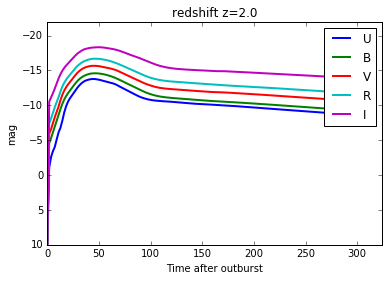

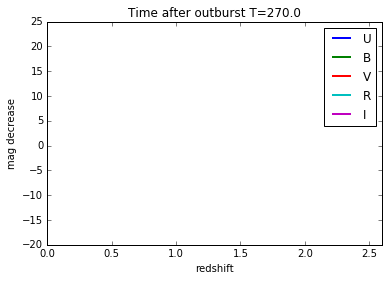

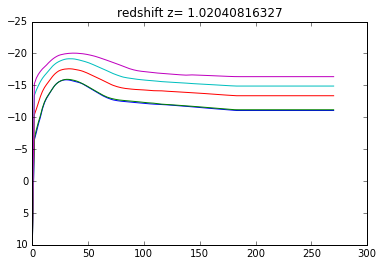

In [12]:
q = int(len(redshifts)/2.)

fig = plt.figure()

plt.plot(TIMES,U[:,q])
plt.plot(TIMES,B[:,q])
plt.plot(TIMES,V[:,q])
plt.plot(TIMES,R[:,q])
plt.plot(TIMES,I[:,q])

plt.gca().invert_yaxis()
plt.title('redshift z= %s' % (redshifts[q]))
plt.show()

Create light curves at T=0, z=0

In [13]:
Uband, Bband, Vband, Rband, Iband = [], [], [], [], []
uband, gband, rband, iband, zband = [], [], [], [], []

for j,T in enumerate(times):
    Uu,Bb,Vv,Rr,Ii = Bessell_Z(times, [0], j)
    uu,gg,rr,ii,zz = sdss_Z(times, [0], j)
    Uband.append(Uu)
    Bband.append(Bb)
    Vband.append(Vv)
    Rband.append(Rr)
    Iband.append(Ii)
    uband.append(uu)
    gband.append(gg)
    rband.append(rr)
    iband.append(ii)
    zband.append(zz)


Times has to be converted to seconds

In [14]:
TIMES = TIMES * 8.64e4

Write the light curve to a file

In [15]:

    
F1 = h5py.File("../LightCurveFiles/%s_UBVRI.hdf5" % Modelname, "w")
F1.create_dataset('times', data = TIMES)
F1.create_dataset('U', data = np.array(Uband).ravel())
F1.create_dataset('B', data = np.array(Bband).ravel())
F1.create_dataset('V', data = np.array(Vband).ravel())
F1.create_dataset('R', data = np.array(Rband).ravel())
F1.create_dataset('I', data = np.array(Iband).ravel())
F1.close()

F2 = h5py.File("../LightCurveFiles/%s_sdss.hdf5" % Modelname, "w")
F2.create_dataset('times', data = TIMES)
F2.create_dataset('u', data = np.array(uband).ravel())
F2.create_dataset('g', data = np.array(gband).ravel())
F2.create_dataset('r', data = np.array(rband).ravel())
F2.create_dataset('i', data = np.array(iband).ravel())
F2.create_dataset('z', data = np.array(zband).ravel())
F2.close()

Write these K corrections data to a file

In [16]:
Format = np.array(["Each color-band X is structured as X(i,j) with i the index of the time and j the index of redshift. 'times' is defined in days. I.e. if U[T=5][Z=1]=2 this means that at redshift z=1, 5 days after the start of the light curve, the magnitude in the U-band is 2 mags fainter."])
File1 =  h5py.File("../LightCurveFiles/Kcorrections/%s_UBVRI.hdf5" % Modelname,"w")
File1.create_dataset('Z', data = redshifts)
File1.create_dataset('times', data = TIMES)
File1.create_dataset('U', data = K_U)
File1.create_dataset('B', data = K_B)
File1.create_dataset('V', data = K_V)
File1.create_dataset('R', data = K_R)
File1.create_dataset('I', data = K_I)
File1.create_dataset('format', data = Format)
File1.close()

File2 =  h5py.File("../LightCurveFiles/Kcorrections/%s_sdss.hdf5" % Modelname,"w")
File2.create_dataset('Z', data = redshifts)
File2.create_dataset('times', data = TIMES)
File2.create_dataset('u', data = K_u)
File2.create_dataset('g', data = K_g)
File2.create_dataset('r', data = K_r)
File2.create_dataset('i', data = K_i)
File2.create_dataset('z', data = K_z)
File2.create_dataset('format', data = Format)
File2.close()